In [2]:
import os, time, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
from PIL import Image
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_PATH = "english.csv"   
BASE_DIR = "."              
IMAGE_SIZE = (28, 28)                  # images will be resized to this
MAX_MISSING_ALLOWED = 0                # if >0 missing images allowed, we proceed with a warning
MLP_GRID_SEARCH = True 

In [4]:
df = pd.read_csv(DATA_PATH)
print("CSV loaded; columns:", df.columns.tolist())

CSV loaded; columns: ['image', 'label']


In [5]:
img_col = None
for c in df.columns:
    if df[c].dtype == object and any(str(v).lower().endswith(('.png','.jpg','.jpeg','.bmp')) for v in df[c].head(5)):
        img_col = c
        break

In [6]:
if img_col is not None:
    # assume other column is label
    label_cols = [c for c in df.columns if c != img_col]
    if len(label_cols) != 1:
        raise RuntimeError("CSV with image path column must have exactly one label column in addition to the image column.")
    label_col = label_cols[0]
    print(f"Detected image path column '{img_col}' and label column '{label_col}'")
    # load images
    def load_image(path, size=IMAGE_SIZE):
        possible_paths = [path, os.path.join(BASE_DIR, path), os.path.join(BASE_DIR, path.lstrip("./"))]
        for p in possible_paths:
            if os.path.exists(p):
                im = Image.open(p).convert("L")
                im = im.resize(size, Image.LANCZOS)
                return np.array(im, dtype=np.float32)
        raise FileNotFoundError(f"Image not found in any expected location: {path}")
    X_list, missing = [], []
    for idx, row in df.iterrows():
        p = row[img_col]
        try:
            arr = load_image(p)
            X_list.append(arr.flatten())
        except Exception as e:
            missing.append((idx, p, str(e)))
            X_list.append(np.zeros(IMAGE_SIZE[0]*IMAGE_SIZE[1], dtype=np.float32))
    if len(missing) > MAX_MISSING_ALLOWED:
        print(f"ERROR: {len(missing)} images missing. Example missing: {missing[:3]}")
        print("Please upload the folder containing the images or set BASE_DIR to the correct path.")
        raise SystemExit("Aborting: image files required but not found.")
    X = np.vstack(X_list)
    y = df[label_col].values
else:
    label_col = df.columns[-1]
    X = df.drop(columns=[label_col]).values.astype(np.float32)
    y = df[label_col].values

Detected image path column 'image' and label column 'label'


In [7]:
# 2) Preprocess
# -----------------------
if X.max() > 1.0:
    X = X / 255.0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
classes = np.unique(y)
n_classes = len(classes)
print(f"Prepared data: train {X_train.shape}, test {X_test.shape}, n_classes {n_classes}")

Prepared data: train (2387, 784), test (1023, 784), n_classes 62


In [8]:
class PLA:
    def __init__(self, n_classes, n_features, learning_rate=0.5, n_epochs=30, random_state=None):
        self.lr = learning_rate
        self.n_epochs = n_epochs
        self.random_state = random_state
        rng = np.random.RandomState(random_state)
        self.W = rng.normal(scale=0.01, size=(n_classes, n_features + 1))
        self.train_errors = []
    def fit(self, X, y):
        n_samples = X.shape[0]
        unique = np.unique(y)
        self.class_to_idx = {c:i for i,c in enumerate(unique)}
        self.idx_to_class = {i:c for c,i in self.class_to_idx.items()}
        y_idx = np.array([self.class_to_idx[yy] for yy in y])
        Xb = np.hstack([X, np.ones((n_samples,1))])
        if self.W.shape[0] != len(unique):
            self.W = np.zeros((len(unique), Xb.shape[1]))
        for epoch in range(self.n_epochs):
            perm = np.random.permutation(n_samples)
            Xb_sh = Xb[perm]; y_sh = y_idx[perm]
            updates = 0
            for i in range(n_samples):
                xi = Xb_sh[i]; yi = y_sh[i]
                for k in range(len(unique)):
                    true = 1 if yi == k else 0
                    activation = np.dot(self.W[k], xi)
                    y_hat = 1 if activation > 0 else 0
                    if y_hat != true:
                        self.W[k] += self.lr * (true - y_hat) * xi
                        updates += 1
            self.train_errors.append(updates / float(n_samples))
        return self
    def decision_function(self, X):
        Xb = np.hstack([X, np.ones((X.shape[0],1))])
        return np.dot(Xb, self.W.T)
    def predict(self, X):
        scores = self.decision_function(X)
        idxs = np.argmax(scores, axis=1)
        return np.array([self.idx_to_class[i] for i in idxs])

In [9]:
pla = PLA(n_classes=n_classes, n_features=X_train.shape[1], learning_rate=0.5, n_epochs=30, random_state=0)
t0 = time.time(); pla.fit(X_train, y_train); t1 = time.time()
print(f"PLA train time: {t1-t0:.2f}s")
y_pred_pla = pla.predict(X_test)
print("PLA test accuracy:", accuracy_score(y_test, y_pred_pla))

PLA train time: 3.38s
PLA test accuracy: 0.18866080156402737


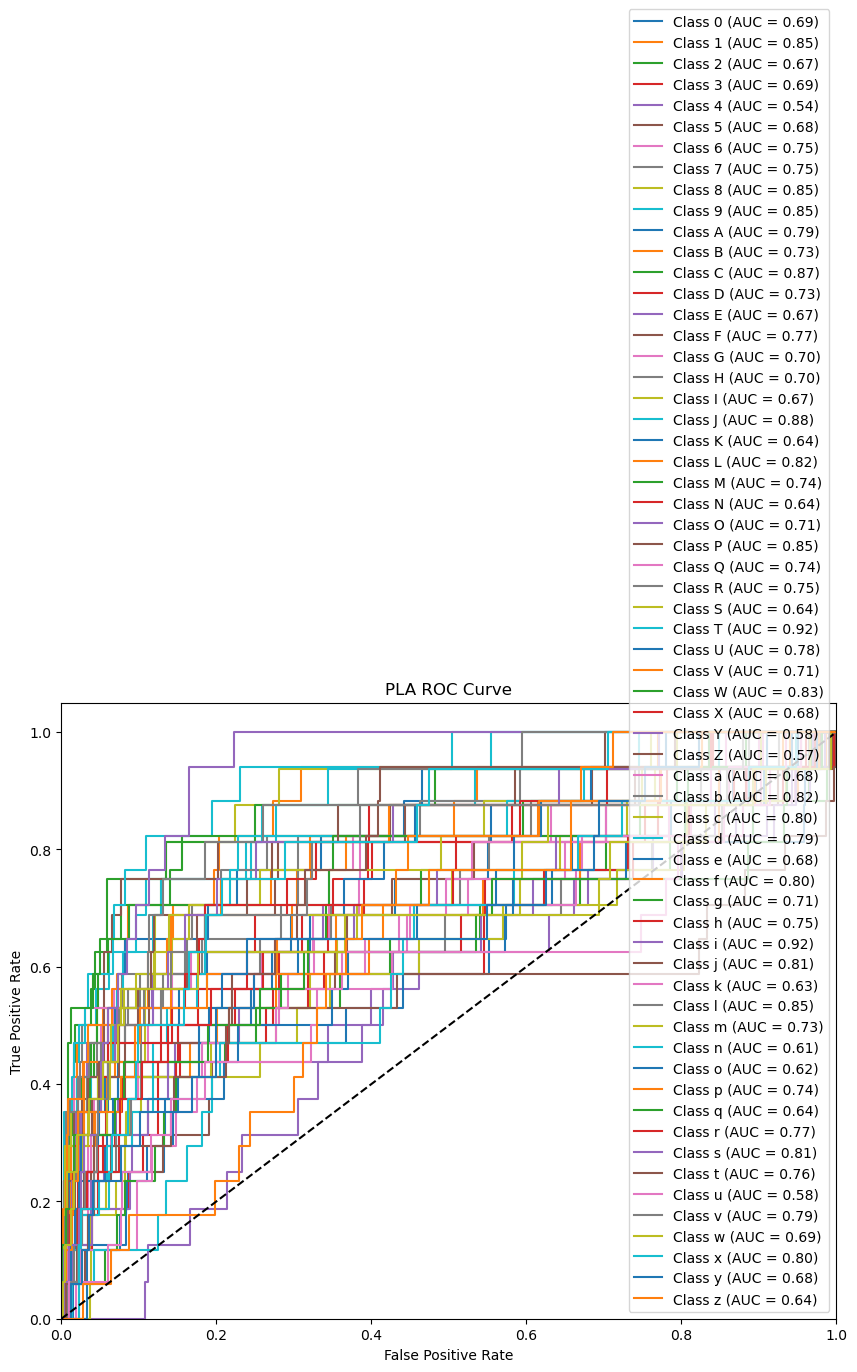

In [28]:
#pla roc curve
y_test_binarized = label_binarize(y_test, classes=classes)
y_score_pla = pla.decision_function(X_test)
fpr_pla = dict(); tpr_pla = dict(); roc_auc_pla = dict()
for i in range(n_classes):
    fpr_pla[i], tpr_pla[i], _ = roc_curve(y_test_binarized[:, i], y_score_pla[:, i])
    roc_auc_pla[i] = auc(fpr_pla[i], tpr_pla[i])
#plot roc curve
plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr_pla[i], tpr_pla[i], label=f'Class {classes[i]} (AUC = {roc_auc_pla[i]:.2f})')  
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PLA ROC Curve')
plt.legend(loc="lower right")
plt.show()

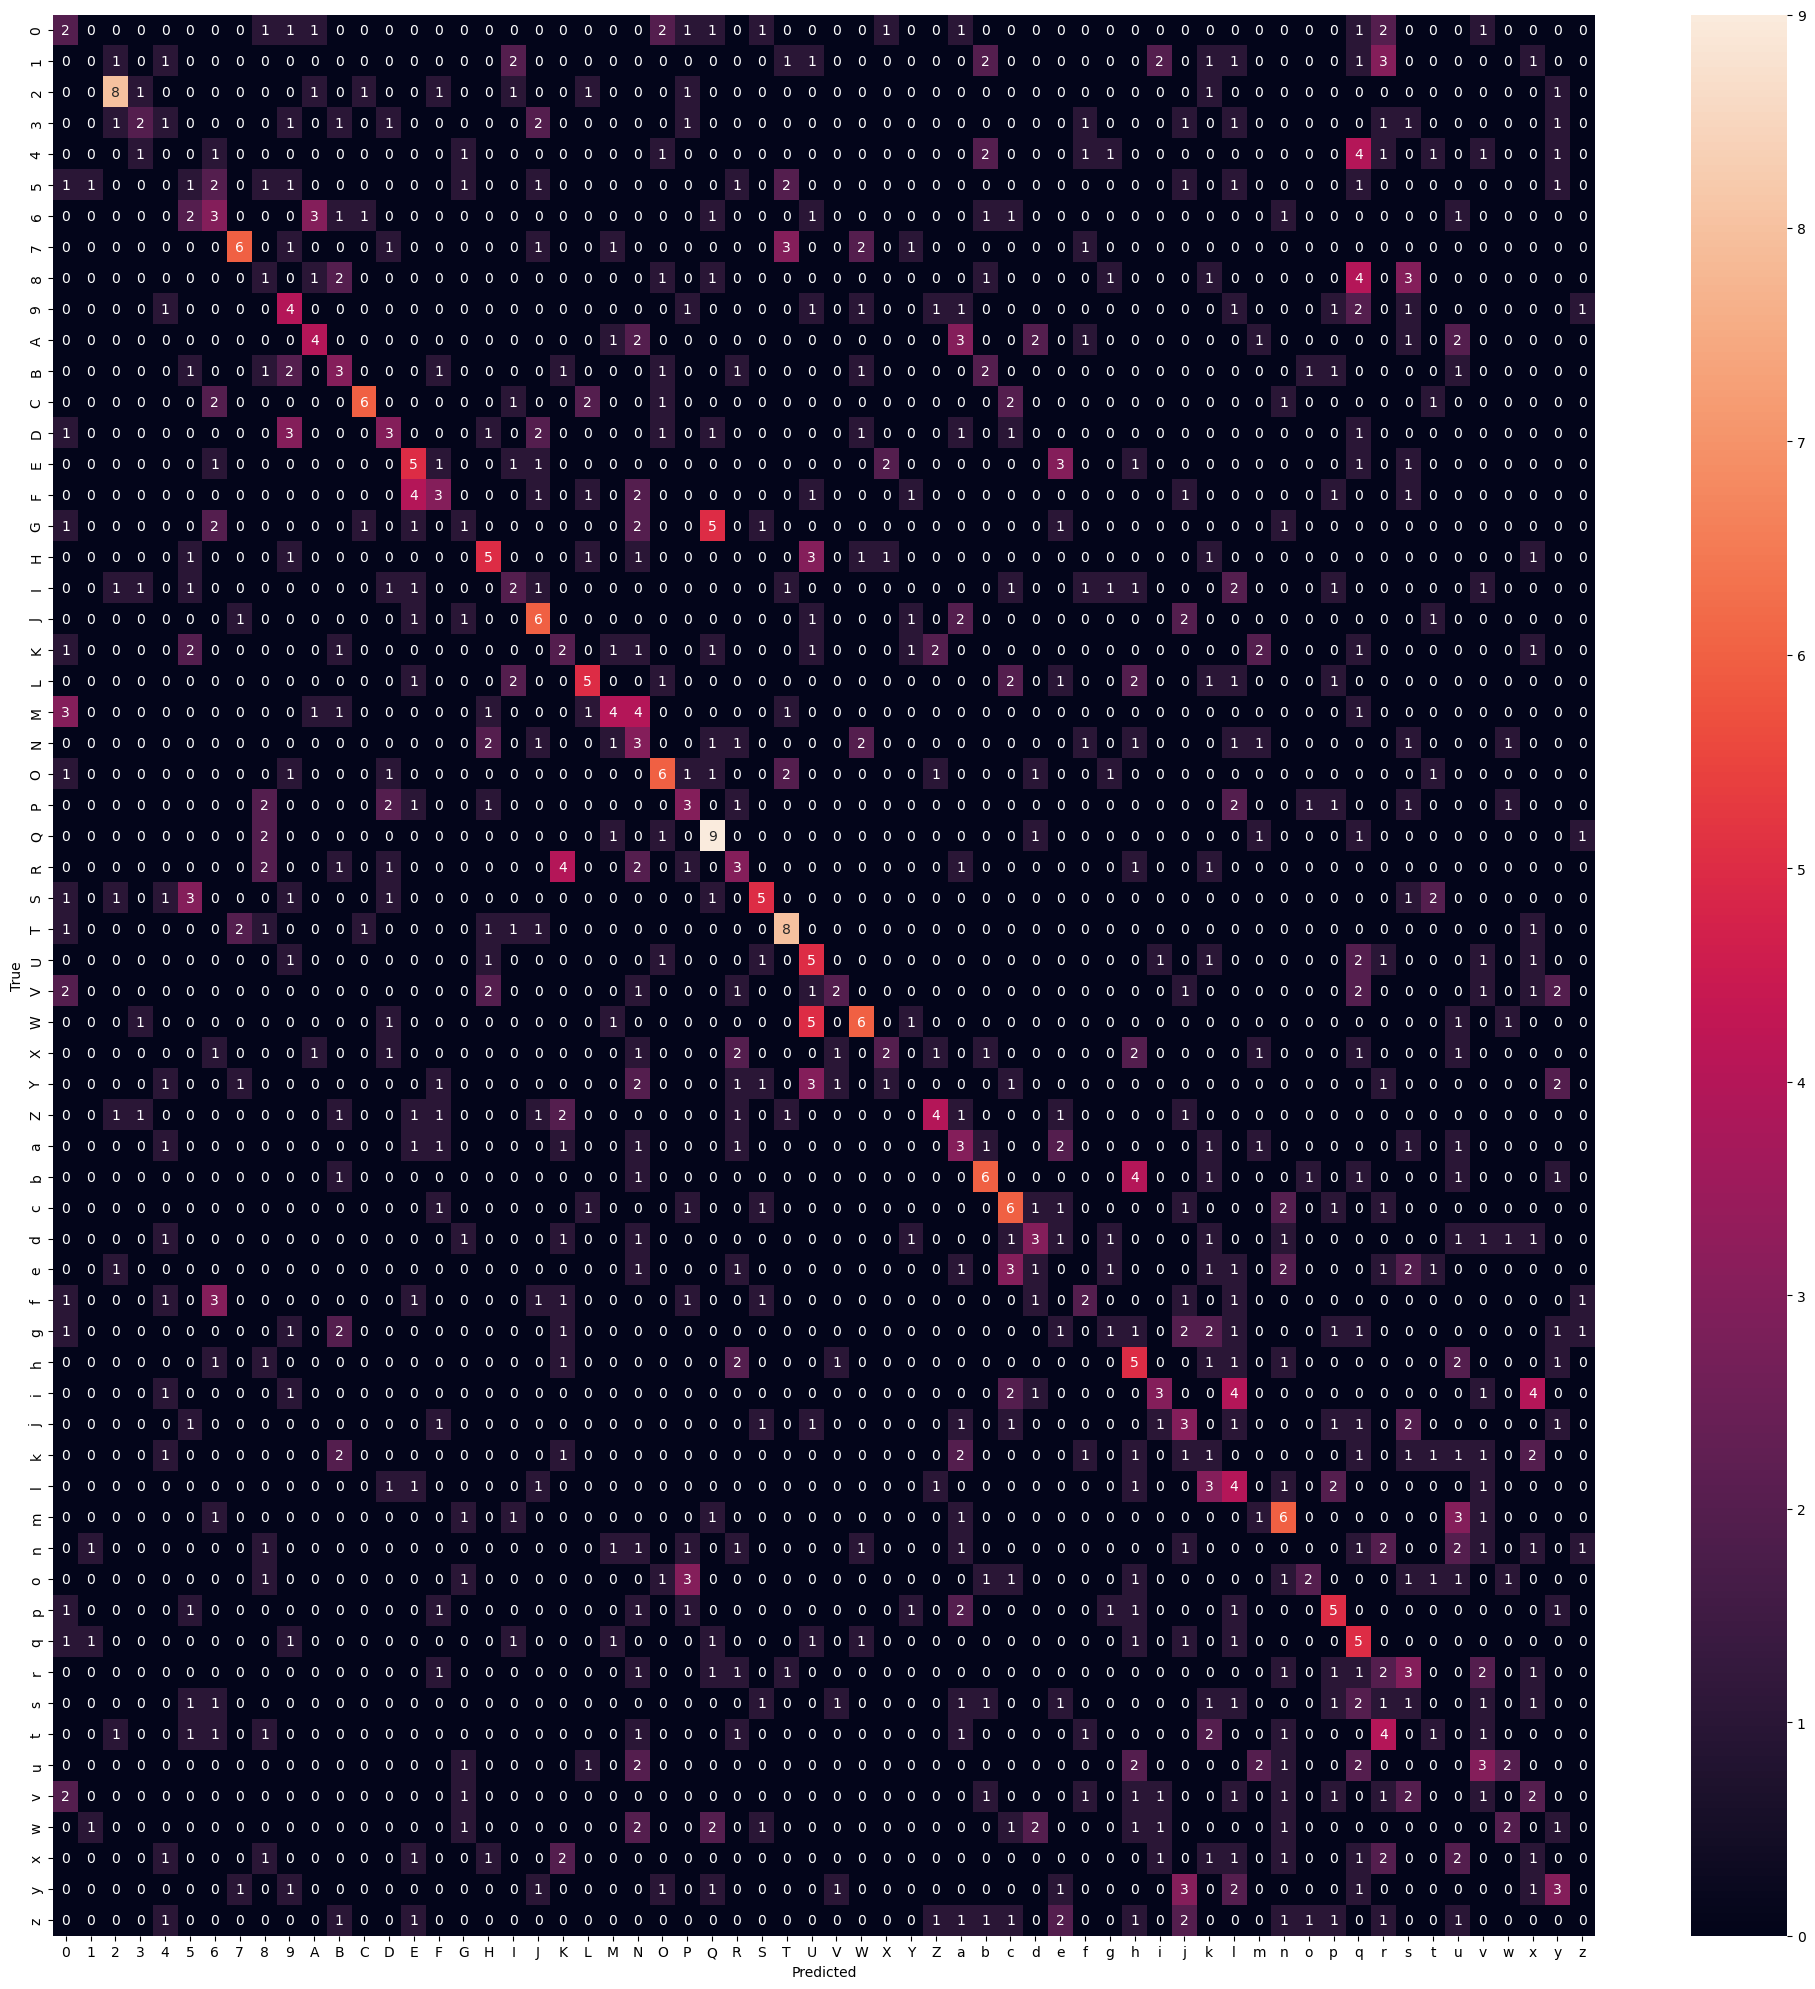

In [19]:
#confusion matrix
cm_pla = confusion_matrix(y_test, y_pred_pla, labels=classes)
plt.figure(figsize=(20,20))
sns.heatmap(cm_pla, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [11]:
# 4) MLP (sklearn) with compact grid search
# -----------------------
if MLP_GRID_SEARCH:
    param_grid = {
        "hidden_layer_sizes": [(256,), (256,128)],
        "activation": ["relu", "tanh", "softmax"],
        "solver": ["adam", "sgd"],
        "learning_rate_init": [1e-3],
        "batch_size": [64]
    }
    mlp = MLPClassifier(max_iter=80, random_state=42, early_stopping=True)
    grid = GridSearchCV(mlp, param_grid, cv=3, n_jobs=1, verbose=1, scoring='accuracy')
    t0 = time.time(); grid.fit(X_train, y_train); t1 = time.time()
    print(f"GridSearch done in {t1-t0:.1f}s. Best params {grid.best_params_}, CV {grid.best_score_:.4f}")
    best_mlp = grid.best_estimator_
else:
    best_mlp = MLPClassifier(hidden_layer_sizes=(256,128), activation='relu', solver='adam', learning_rate_init=1e-3, batch_size=64, max_iter=80, early_stopping=True, random_state=42)
    best_mlp.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
GridSearch done in 286.1s. Best params {'activation': 'relu', 'batch_size': 64, 'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.001, 'solver': 'adam'}, CV 0.3900


In [12]:
t0 = time.time(); y_pred_mlp = best_mlp.predict(X_test); t1 = time.time()
print(f"MLP test accuracy: {accuracy_score(y_test, y_pred_mlp)}, prediction time {t1-t0:.2f}s")

MLP test accuracy: 0.45161290322580644, prediction time 0.01s


In [13]:
# -----------------------
# 5) Evaluation: classification report, confusion matrix, ROC micro/macro, convergence plots
# -----------------------
print("\nPLA classification report:\n", classification_report(y_test, y_pred_pla, zero_division=0))



PLA classification report:
               precision    recall  f1-score   support

           0       0.10      0.12      0.11        16
           1       0.00      0.00      0.00        17
           2       0.53      0.47      0.50        17
           3       0.29      0.12      0.17        16
           4       0.00      0.00      0.00        16
           5       0.07      0.06      0.06        16
           6       0.16      0.19      0.17        16
           7       0.55      0.35      0.43        17
           8       0.06      0.06      0.06        16
           9       0.19      0.25      0.22        16
           A       0.33      0.24      0.28        17
           B       0.18      0.18      0.18        17
           C       0.60      0.38      0.46        16
           D       0.21      0.19      0.20        16
           E       0.25      0.29      0.27        17
           F       0.23      0.19      0.21        16
           G       0.10      0.06      0.08        1

In [14]:
print("\nMLP classification report:\n", classification_report(y_test, y_pred_mlp, zero_division=0))


MLP classification report:
               precision    recall  f1-score   support

           0       0.38      0.38      0.38        16
           1       0.36      0.47      0.41        17
           2       0.48      0.59      0.53        17
           3       0.32      0.38      0.34        16
           4       0.30      0.19      0.23        16
           5       0.26      0.31      0.29        16
           6       0.44      0.50      0.47        16
           7       0.50      0.59      0.54        17
           8       0.43      0.56      0.49        16
           9       0.47      0.56      0.51        16
           A       0.57      0.76      0.65        17
           B       0.46      0.35      0.40        17
           C       0.62      0.62      0.62        16
           D       0.58      0.44      0.50        16
           E       0.62      0.47      0.53        17
           F       0.59      0.62      0.61        16
           G       0.50      0.44      0.47        1

PLA micro AUC 0.7346, macro AUC 0.7346
MLP  micro AUC 0.9206, macro AUC 0.9185


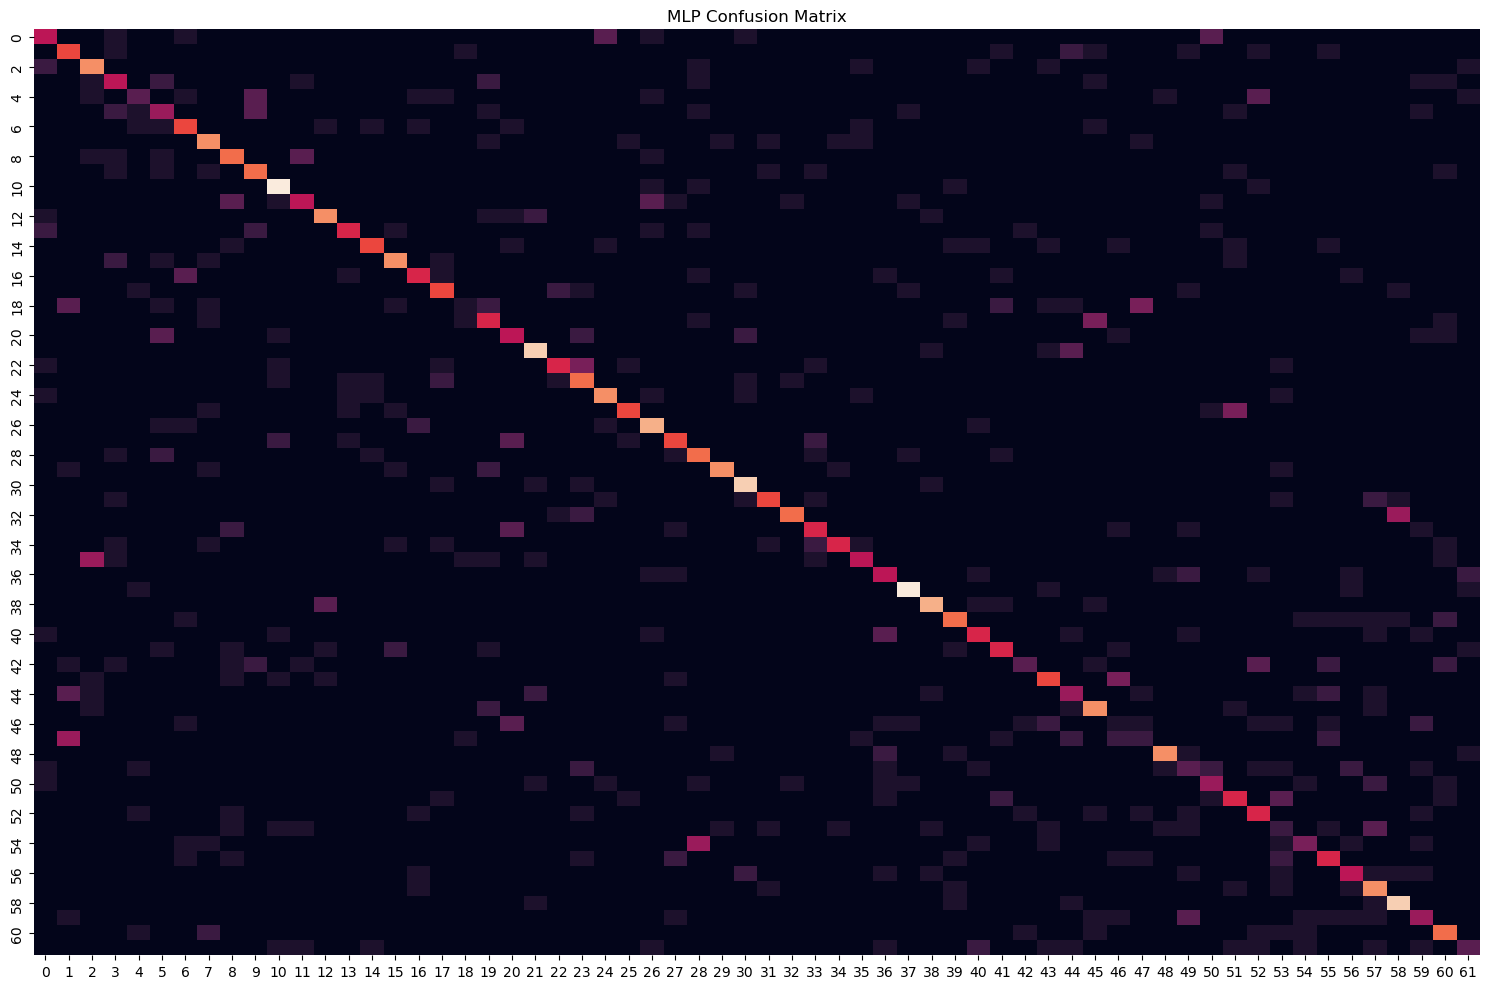

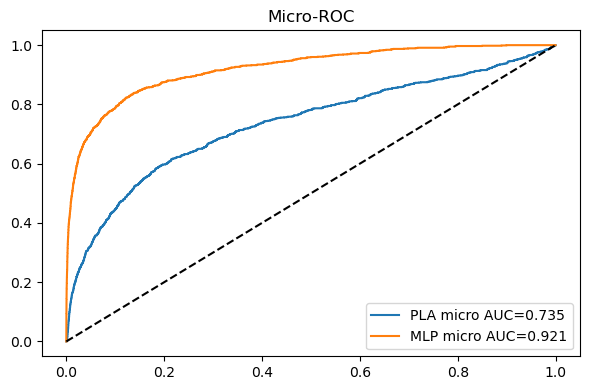

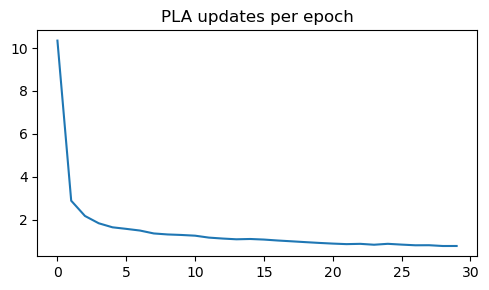

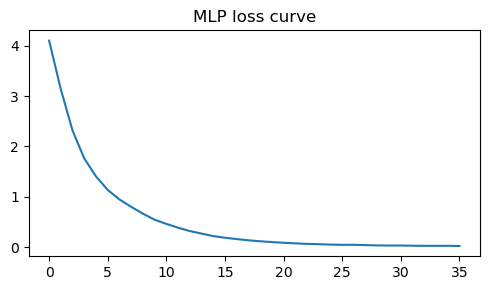

In [ ]:
# ROC setup
y_test_b = label_binarize(y_test, classes=classes)
# PLA scores aligned to classes
scores_pla = pla.decision_function(X_test)
pla_cols = [pla.idx_to_class[i] for i in range(len(pla.idx_to_class))]
scores_pla_aligned = np.zeros((X_test.shape[0], len(classes)))
for j, cls in enumerate(classes):
    if cls in pla_cols:
        idx = pla_cols.index(cls)
        scores_pla_aligned[:, j] = scores_pla[:, idx]
    else:
        scores_pla_aligned[:, j] = 0.0
# MLP probabilities
if hasattr(best_mlp, "predict_proba"):
    probs_mlp = best_mlp.predict_proba(X_test)
else:
    dec = best_mlp.decision_function(X_test)
    expd = np.exp(dec - np.max(dec, axis=1, keepdims=True))
    probs_mlp = expd / np.sum(expd, axis=1, keepdims=True)

def compute_roc(y_true_b, scores):
    fpr = {}; tpr = {}; roc_auc = {}
    for i in range(y_true_b.shape[1]):
        try:
            fpr[i], tpr[i], _ = roc_curve(y_true_b[:, i], scores[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        except Exception:
            fpr[i], tpr[i], roc_auc[i] = np.array([0,1]), np.array([0,1]), 0.5
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_b.ravel(), scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    roc_auc["macro"] = np.mean([v for k,v in roc_auc.items() if isinstance(k,int)])
    return fpr, tpr, roc_auc

fpr_pla, tpr_pla, aucs_pla = compute_roc(y_test_b, scores_pla_aligned)
fpr_mlp, tpr_mlp, aucs_mlp = compute_roc(y_test_b, probs_mlp)
print(f"PLA micro AUC {aucs_pla['micro']:.4f}, macro AUC {aucs_pla['macro']:.4f}")
print(f"MLP  micro AUC {aucs_mlp['micro']:.4f}, macro AUC {aucs_mlp['macro']:.4f}")

# Plots (display)
plt.figure(figsize=(15,10)); sns.heatmap(confusion_matrix(y_test, y_pred_mlp, labels=classes), cbar=False); plt.title("MLP Confusion Matrix"); plt.tight_layout()
plt.figure(figsize=(6,4)); plt.plot(fpr_pla["micro"], tpr_pla["micro"], label=f'PLA micro AUC={aucs_pla["micro"]:.3f}'); plt.plot(fpr_mlp["micro"], tpr_mlp["micro"], label=f'MLP micro AUC={aucs_mlp["micro"]:.3f}'); plt.plot([0,1],[0,1],'k--'); plt.legend(); plt.title("Micro-ROC"); plt.tight_layout()
plt.figure(figsize=(5,3)); plt.plot(pla.train_errors); plt.title("PLA updates per epoch"); plt.tight_layout()
if hasattr(best_mlp, "loss_curve_"): plt.figure(figsize=(5,3)); plt.xlabel("epochs");plt.ylabel("loss");plt.plot(best_mlp.loss_curve_); plt.title("MLP loss curve"); plt.tight_layout()


In [16]:
# Save models
joblib.dump(pla, "pla_ovr.pkl")
joblib.dump(best_mlp, "best_mlp.pkl")
print("Models saved to : pla_ovr.pkl and best_mlp.pkl")

Models saved to : pla_ovr.pkl and best_mlp.pkl


In [32]:
def plot_multi_model_macro_roc(y_true, scores_dict, classes):
    """
    Computes and plots the overall macro-averaged ROC curve for multiple models.

    Args:
        y_true: True labels (n_samples,)
        scores_dict: A dictionary where keys are model names (str) and values 
                     are their corresponding scores (n_samples, n_classes).
        classes: A list of all unique class labels.
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 8))
    
    # Define a list of colors and linestyles for different models
    colors = ['deeppink', 'navy', 'aqua', 'darkorange']
    linestyles = [':', '--', '-.', '-']
    
    # Binarize the true labels once for all models
    y_true_binarized = label_binarize(y_true, classes=classes)
    n_classes = y_true_binarized.shape[1]

    # Iterate through each model's scores
    for i, (model_name, y_scores) in enumerate(scores_dict.items()):
        
        # Dictionaries to store ROC curve data for the current model
        fpr_per_class = {}
        tpr_per_class = {}
        
        # Compute ROC curve for each class
        for j in range(n_classes):
            try:
                fpr_per_class[j], tpr_per_class[j], _ = roc_curve(y_true_binarized[:, j], y_scores[:, j])
            except ValueError:
                fpr_per_class[j], tpr_per_class[j] = np.array([0, 1]), np.array([0, 1])

        # --- Compute Macro-Averaged ROC Curve for the current model ---
        all_fpr = np.unique(np.concatenate([fpr_per_class[k] for k in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)
        for k in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr_per_class[k], tpr_per_class[k])
        mean_tpr /= n_classes
        
        macro_auc = auc(all_fpr, mean_tpr)

        # Plot the macro-averaged ROC curve for the current model
        plt.plot(all_fpr, mean_tpr,
                 label=f'{model_name} Macro-average ROC (area = {macro_auc:0.4f})',
                 color=colors[i % len(colors)], 
                 linestyle=linestyles[i % len(linestyles)], 
                 linewidth=3)

    # --- Finalize the plot ---
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Comparative Macro-Averaged ROC Curves', fontsize=14)
    plt.legend(loc="lower right", fontsize=11)
    plt.show()

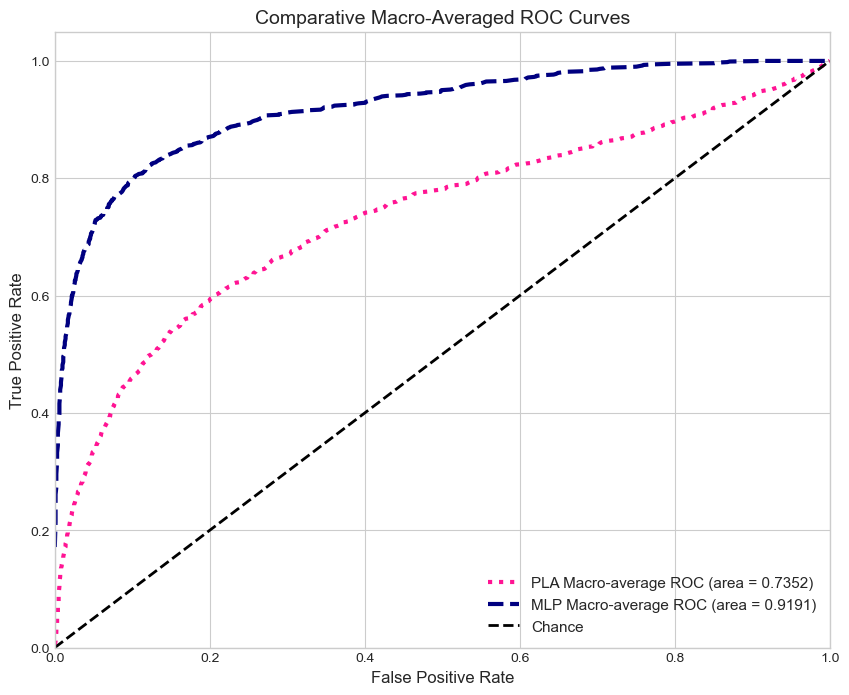

In [33]:
model_scores = {
        'PLA': scores_pla_aligned,
        'MLP': probs_mlp
}
plot_multi_model_macro_roc(y_test, model_scores, classes)